In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3635308869


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 10,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 150,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 1,
 'scheduler': 'cosine_schedule_with_warmup',
 'lr_end': 2e-06,
 'power': 0.6,
 'freeze_from_steps': -1,
 'seed': 3635308869,
 'num_epoch': 10,
 'to_freeze_count': 150}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /home/awsw-dev/.cache/huggingface/datasets/text/default-7b4e601c7343f186/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


Token indices sequence length is longer than the specified maximum sequence length for this model (3034 > 2048). Running this sequence through the model will result in indexing errors


Dataset demo snapshot:
<p> <msg> c "Can't you locate it again?" <d> <msg> Br "We don't know how." <d> <msg> Br "We found a different set of coordinates in there, but for some reason, we aren't able to use them."<|endoftext|><p> <msg> c "I think it does." <p> <msg> c "By the way, Ipsum, you're not from here, right?" <d> <msg> Ip "What is that supposed to mean?"<|endoftext|><p> <msg> c "..." <d> <msg
> Em "..." <d> <msg> Em "..." <d> <msg> Em "..."<|endoftext|><d> <scn>bareblur <msg> Br "Anyways, how do you like it here so far? I mean, compared to wherever it is that you came from." <p> <msg> c "I'm having a drinking contest with a dragon. How could I not love this?" <d> <msg> Br "We'll see how much you like it when I've drunk you under the table." <d> <scn>bareblur <msg> Br "
[0] set freeze_part_layers: True (freezing 150 out of 160 layers.)


Step,Training Loss
4,3.502600
8,3.339600
12,3.143300
16,2.843800
20,2.846600
24,2.580100
28,2.634000
32,2.420400
36,2.496100
40,2.367200


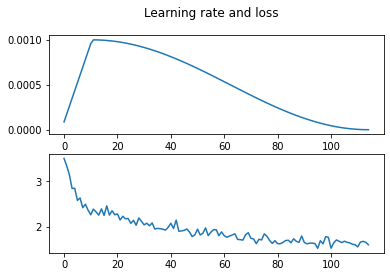

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [8]:
prompts = [
    ('msg p c "Hey Remy!" msg d Ry "Hey!"', "How are you?"),
    ('msg p c "I was with Lorem today." msg d Ad "Very nice."', "What do you think of Lorem?"),
    ('msg d m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('msg d m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: <msg>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]


Prompt: What do you think of Lorem?
Reply: <msg> Ad "I was with Lorem today." <p>I was with Lorem today." <d> <msg> Ad "Very nice." <p>I was with Lorem today." <d> <msg> Ad "Very nice." <p>I was with Lorem today." <d> <msg> Ad "Very nice." <p>I was with Lorem today." <d> <msg> Ad "Very


Prompt: Oh my god, Adine. What is this?
Reply: <msg> Ad "I'm not sure, but I think it's a sign."<d> <msg> Ad "I think it's a sign."<d> <msg> Ad "I think it's a sign."<d> <msg> Ad "I think it's a sign."<d> <msg> Ad "I think it's a sign."<d> <msg> Ad "I think it's a sign."


Prompt: What will we do here?
Reply: <msg>An "I sat down on a chair in Anna's lab."<d> <msg>An "I sat down on a chair in Anna's lab."<d> <msg>An "I sat down on a chair in Anna's lab."<d> <msg

# Sampling test

Which combination is the best?

In [ ]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 12, top_p: 0.02] -> Prompt: How are you?
Reply: <msg>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]!" <p>p "Hey, [player_name]

[Test 1 top_k: 12, top_p: 0.02] -> Prompt: What do you think of Lorem?
Reply: <msg> Ad "I was with Lorem today." <p>I was with Lorem today." <d> <msg> Ad "Very nice." <p>I was with Lorem today." <d> <msg> Ad "Very nice." <p>I was with Lorem today." <d> <msg> Ad "Very nice." <p>I was with Lorem today." <d> <msg> Ad "Very

[Test 1 top_k: 12, top_p: 0.02] -> Prompt: Oh my god, Adine. What is this?
Reply: <msg> Ad "I'm not sure, but I think it's a sign."<d> <msg> Ad "I think it's a sign."<d> <msg> Ad "I think it's a sign."<d> <msg> Ad "I think it's a sign."<d> <msg> Ad "I think it's a sign."<d> <msg> Ad "I think it's a sign."

[Test 1 top_k: 12, top_p: 0.02] -> Prompt: What will we do here?
Reply: <msg>An "I sat do

In [ ]:
print("What to say?")
print(generate_dragon_reply("", input()))